In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

In [2]:
# extract module path from cwd
module_path = '/'.join(os.getcwd().split('/')[:-1])
# add dimred module to search path
sys.path.append(module_path)
# obtain datafolder from module path path
data_path = module_path + '/datasets/guass/' # for using other datasets replace "guass"
data_path

'/home/anirudhj/research/dev/dim-red/datasets/guass/'

In [3]:
# Extract actual data
x_data = np.fromfile(data_path+"x_b2.txt", sep=' ')
y_data = np.fromfile(data_path+"y_b2.txt", sep=' ')
data = np.array([x_data,y_data]).T

Text(0, 0.5, '$x_2$')

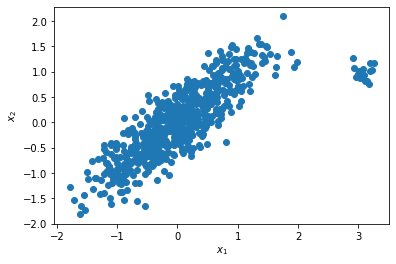

In [4]:
plt.scatter(*data.T)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

In [5]:
V,S,U = np.linalg.svd(data,full_matrices=False) # Perform SVD to obtain Principal components

In [6]:
def colorgen(colora="rgbk"):
    for i in colora:
        yield i
cgen = colorgen("rbgk")
def plotVec(V,ax,namer="None",a=0,c='r'):
    V += a
#     c = next(cgen)
    ax.plot([a,V[0,0]],[a,V[0,1]],'-'+c,linewidth=3, label=r"$1^{st} PC$")
    ax.plot([a,V[1,0]],[a,V[1,1]],'--'+c,linewidth=2,label=r"$2^{nd} PC$")
    ax.legend()

Text(0, 0.5, '$x_2$')

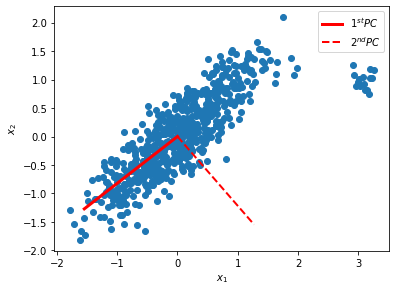

In [7]:
fig,ax = plt.subplots(figsize=(6,4.5))
ax.plot(*data.T, 'o')

plotVec(2*U,ax,"Variance")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

## Low dim

In [8]:
pc = U[0]
## Picked first principle vector

xr = np.dot(data,pc) ## reduced
xp = np.outer(xr,pc) ## Predicted

In [9]:
print(xr.shape)
print(pc.shape)

(625,)
(2,)


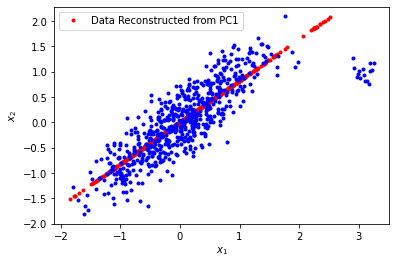

In [10]:
plt.plot(*xp.T,'.r', label='Data Reconstructed from PC1')
plt.plot(*data.T,'.b')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()

## Make up a source term

In [11]:
x1,y1 = data.T
print(x1.shape)
print(y1.shape)
print(data.shape)

(625,)
(625,)
(625, 2)


In [12]:
z1 = np.exp(0.62*(3.1*x1-2.08*y1))
z1.shape

(625,)

In [13]:
n = 610

Text(0, 0.5, '$f(x_1,x_2)$')

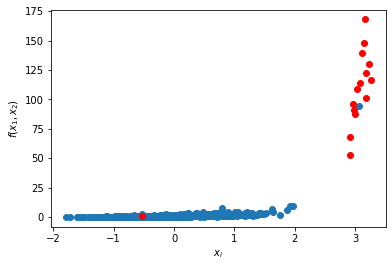

In [14]:
plt.plot(x1[:n],z1[:n],'o')
plt.plot(x1[n:],z1[n:],'ro')
plt.xlabel(r"$x_i$")
plt.ylabel(r"$f(x_1,x_2)$")

In [15]:
pc1 = U[0]
xr = np.dot(data,pc1)

In [16]:
xp = np.outer(xr,pc1)

**Recaculate source term from the predicted data: xp**

In [17]:
from sklearn.ensemble import RandomForestRegressor

## Random Forest (or Bootstrap Aggregation) should perform better that
## General additive model, (Mars for eg), Ref: Tibishirani, ESL page 322

In [18]:
model = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model.fit(xp,z1)  ### should be zp? Check 1#

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)

In [19]:
zp = model.predict(xp)

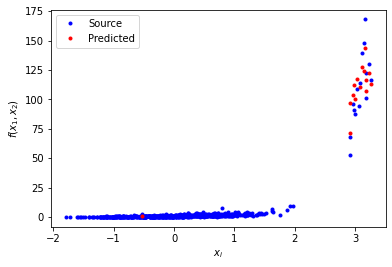

In [20]:
plt.plot(x1,z1,"b.",label="Source")
plt.plot(x1[n:],zp[n:],"r.",label="Predicted")
plt.xlabel(r"$x_i$")
plt.ylabel(r"$f(x_1,x_2)$")

plt.legend()

In [21]:
print("MSE is ",np.mean(np.abs(zp-z1)))

MSE is  0.6194757370265896


## Combinator

In [22]:
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [23]:
modeldict = dict({
                  'linear' : LinearRegression(),
                  'svm' : SVR(),
                  'forest': RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100),
                  'knn' : KNeighborsRegressor(),
                  'neural' : MLPRegressor()})

In [24]:
from dimred.models.linear.transform import co_kurtosis, co_variance

def encode(x,method=co_variance):
    cm = method(x)
    V,S,U = np.linalg.svd(cm,full_matrices=False)
    pc = U[0] ### U[:1] num of vectors to chose
    xr = np.dot(x,pc)
    xe = np.outer(xr,pc)
    return xe ## encoded set

def decode(z,xp,model):
    model.fit(xp,z)
    zp = model.predict(xp)
    return zp

In [25]:
def mse(a,ap):
    return np.mean((a-ap)**2)

def tse(x,y):
    _conv = lambda x : np.array(x).T    
    x = _conv(x)
    y = _conv(y)
    return np.linalg.norm(x-y,ord=1,axis=1).sum()

mse = lambda a,ap: np.mean(np.abs(a-ap))

In [26]:
dat = dict({'x':x1,'y':y1,'s':z1}) # training data

In [27]:
pcdict = dict({'variance':co_variance, 'kurtosis':co_kurtosis})

def comma(verbose=True,fi='x',si='s',enc=co_variance,dec=modeldict['linear']):
    xa = dat[fi]
    ya = dat[si]
    xen = encode(data,method=enc)
    xp = decode(xa,xen,model=dec)
    yp = decode(ya,xen,model=dec)

    if verbose:
        plt.plot(xa,ya,".",label="Original")
        plt.plot(xp,yp,"r.",label="Predicted")
        plt.xlabel(fi)
        plt.ylabel(si)
        plt.title(str(dec)[:16])
        plt.legend()
        plt.show()
    e1,e2 = mse(x1,xp),mse(y1,yp)
    e3 = tse([x1,y1],[xp,yp])
    
    if verbose:
        print(f""" method {enc},
        Reconstruction
        x error {e1} 
        y error {e2}
        total err {e3}
        """)
    return e1,e2,e3
    
interact(comma,verbose=[True,False],fi=['x','y'],si=['y','s'],enc=pcdict,dec=modeldict)

interactive(children=(Dropdown(description='verbose', options=(True, False), value=True), Dropdown(description…

<function __main__.comma(verbose=True, fi='x', si='s', enc=<function co_variance at 0x7f303af82ca0>, dec=LinearRegression())>

In [28]:
results = {}
for k,v in pcdict.items():
    results[k] = {}
    for n,m in modeldict.items():
        e1,e2,e3 = comma(enc=v,dec=m,verbose=False)
        results[k][n] = [e1,e2,e3]

/home/anirudhj/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anirudhj/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
import pandas as pd
pd.DataFrame(results)

,variance,kurtosis
linear,"[0.15768770768506435, 6.353946338906639, 4069....","[0.04482506424164107, 7.291479594935096, 4585...."
svm,"[0.13299308137180885, 1.4607932688276861, 996....","[0.040214175694771384, 1.5996832440843978, 102..."
forest,"[0.05908149885488015, 3.9462537629479617, 2503...","[0.01693444141724807, 3.8576718666594285, 2421..."
knn,"[0.12161956902080001, 3.9965024272201175, 2573...","[0.03487223579519999, 3.9050915974808924, 2462..."
neural,"[0.14939506662125288, 4.255310625456183, 2752....","[0.060163082323956237, 4.64457336665265, 2940...."


In [30]:
errs = []
for i in range(3):
    errs.append({})
    for k,v in results.items():
        errs[i][k] = {}
        for m,eri in v.items():
            errs[i][k][m] = eri[i]


Text(0.5, 1.0, 'Species reconstruction error')

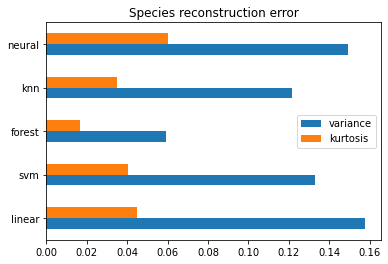

In [31]:
df1 = pd.DataFrame(errs[0])

df1.plot.barh()
plt.title("Species reconstruction error")